<a href="https://colab.research.google.com/github/nabojyoti/LLM-Finetuning-Playground/blob/main/Fine_Tune_LLAMA_2_Using_QLoRA_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of the SFFT and RLHF:
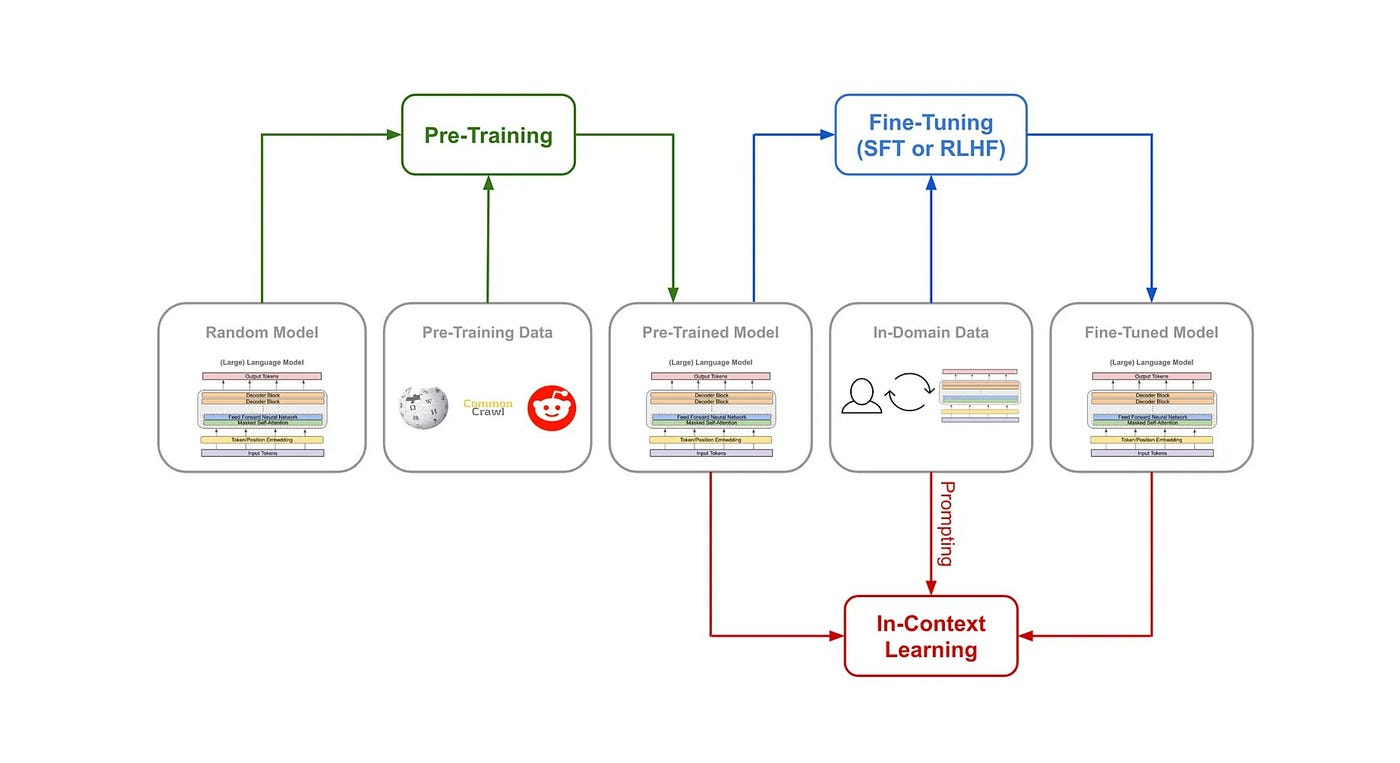

In [ ]:
!pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install transformers==4.31
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install evaluate
!pip install -qqq trl==0.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 k

In [ ]:
import torch
import time
import evaluate
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import random

In [ ]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


###  Preprocess the Dialog-Summary Dataset

You need to convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with `Summarize the following conversation` and to the start of the summary with `Summary` as follows:

Training prompt (dialogue):
```
Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary:
```

Training response (summary):
```
Both Chris and Antje participated in the conversation.
```

Then preprocess the prompt-response dataset into tokens and pull out their `input_ids` (1 per token).

In [ ]:
def format_instruction(dialogue: str, summary: str):
	return f"""### Instruction:
Summarize the following conversation.

### Input:
{dialogue.strip()}

### Summary:
{summary}
""".strip()


In [ ]:
def generate_instruction_dataset(data_point):

    return {
        "dialogue": data_point["dialogue"],
        "summary": data_point["summary"],
        "text": format_instruction(data_point["dialogue"],data_point["summary"])
    }

In [ ]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42)
        .map(generate_instruction_dataset).remove_columns(['id', 'topic',])
    )

In [ ]:
sample_dataset = dataset.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:

sample_dataset["train"] = process_dataset(sample_dataset["train"])
sample_dataset["test"] = process_dataset(sample_dataset["validation"])
sample_dataset["validation"] = process_dataset(sample_dataset["validation"])

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
## APPLYING PREPROCESSING ON WHOLE DATASET
dataset["train"] = process_dataset(dataset["train"])
dataset["test"] = process_dataset(dataset["validation"])
dataset["validation"] = process_dataset(dataset["validation"])
# Select 1000 rows from the training split
train_data = dataset['train'].shuffle(seed=42).select([i for i in range(500)])

# Select 100 rows from the test and validation splits
test_data = dataset['test'].shuffle(seed=42).select([i for i in range(50)])
validation_data = dataset['validation'].shuffle(seed=42).select([i for i in range(50)])

train_data,test_data,validation_data

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

(Dataset({
     features: ['dialogue', 'summary', 'text'],
     num_rows: 500
 }),
 Dataset({
     features: ['dialogue', 'summary', 'text'],
     num_rows: 50
 }),
 Dataset({
     features: ['dialogue', 'summary', 'text'],
     num_rows: 50
 }))

In [ ]:
sample_dataset["train"]["text"][0]

"### Instruction:\nSummarize the following conversation.\n\n### Input:\n#Person1#: Hey man, you wanna buy some weed?\n#Person2#: Some what?\n#Person1#: Weed! You know? Pot, Ganja, Mary Jane some chronic!\n#Person2#: Oh, umm, no thanks.\n#Person1#: I also have blow if you prefer to do a few lines.\n#Person2#: No, I am ok, really.\n#Person1#: Come on man! I even got dope and acid! Try some!\n#Person2#: Do you really have all of these drugs? Where do you get them from?\n#Person1#: I got my connections! Just tell me what you want and I ' ll even give you one ounce for free.\n#Person2#: Sounds good! Let ' s see, I want.\n#Person1#: Yeah?\n#Person2#: I want you to put your hands behind your head! You are under arrest!\n\n### Summary:\n#Person1# tries to sell drugs to #Person2#, then #Person1# is arrested by #Person2#."

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id =  "NousResearch/Llama-2-7b-hf"
# model_id = "meta-llama/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

## ZERO-SHOT INFERENCE WITH LLAMA-2 7B

In [ ]:
index = 0

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

### Input:
{dialogue}

### Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=100,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1468: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

### Input:
#Person1#: Did you enjoy your weekend at the highland hotel? I heard it's and excellent place to stay and has good facilities.
#Person2#: I had a wonderful time. The rooms are not very big, but they are well furnished. The restaurant is excellent and reasonably priced. There's a sauna and a Jacuzzi.
#Person1#: Do they have a swimming pool?
#Person2#: No, they don't. they have a beauty parlor, but I didn't go there.
#Person1#: What's the service like?
#Person2#: It's very good. Check in and check out at the reception only took a few minutes. The wait staff is very good. A waiter recommended their baked fish, which tasted wonderful. The hotel was quite full, so I'd suggest making a reservation if you intend to go there. The hotel offers a discount at the weekends.
#Person1#: It sounds perfect. Did you have any complaints at a

# Training Setup

### LoRA Explained
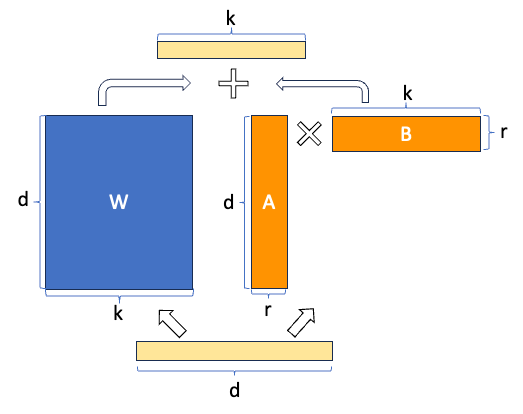

### Merging LoRA ADAPTER With BASE MODEL
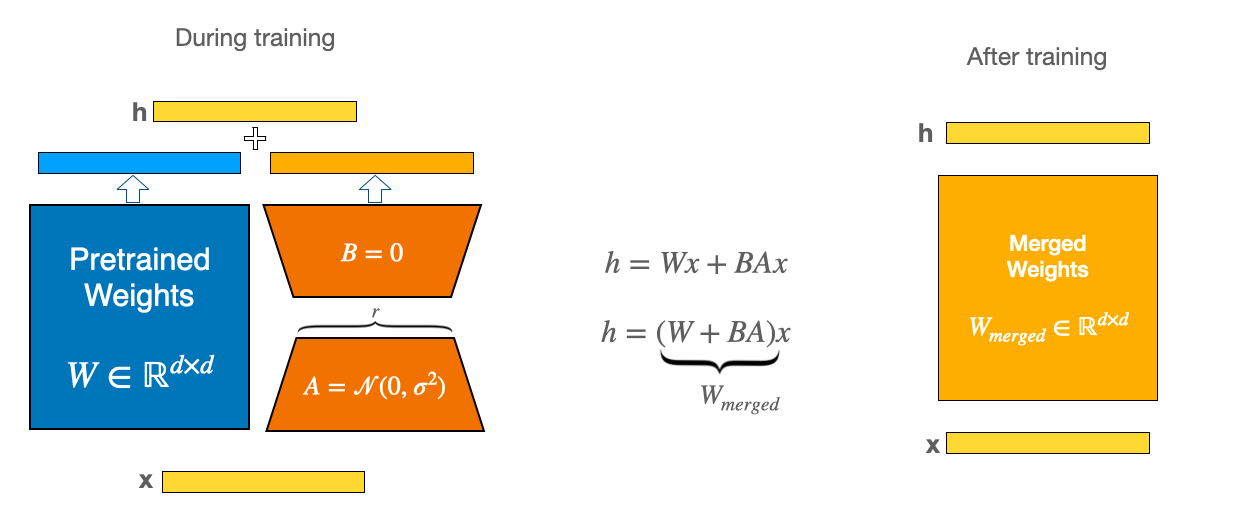

Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():

        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=64,
    # target_modules=["query_key_value"],
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], #specific to Llama models.
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

trainable params: 16777216 || all params: 3517190144 || trainable%: 0.477006226934315


# Training

Run the cell below to run the training! For the sake of the demo, we just ran it for few steps just to showcase how to use this integration with existing tools on the HF ecosystem.

In [ ]:
OUTPUT_DIR = "llama2-docsum-adapter"

%load_ext tensorboard
%tensorboard --logdir llama2-docsum-adapter/runs

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [ ]:
from trl import SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=validation_data,
    peft_config=lora_config,
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
)

trainer.train()

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
13,1.295800,1.325181
26,1.308200,1.275199
39,1.251400,1.254708
52,1.103600,1.253170


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=62, training_loss=1.2804688167187475, metrics={'train_runtime': 1307.8652, 'train_samples_per_second': 0.765, 'train_steps_per_second': 0.047, 'total_flos': 6161813997944832.0, 'train_loss': 1.2804688167187475, 'epoch': 1.98})

In [ ]:
peft_model_path="./peft-dialogue-summary"

trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-dialogue-summary/tokenizer_config.json',
 './peft-dialogue-summary/special_tokens_map.json',
 './peft-dialogue-summary/tokenizer.json')

# Inference

In [ ]:
from transformers import TextStreamer
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

peft_model_dir = "peft-dialogue-summary"

# load base LLM model and tokenizer
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(peft_model_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
index = 0

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

### Input:
{dialogue}

### Summary:
"""

input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
# output = tokenizer.decode(
#     trained_model.generate(
#         inputs_ids,
#         max_new_tokens=100,
#     )[0],
#     skip_special_tokens=True
# )
outputs = trained_model.generate(input_ids=input_ids, max_new_tokens=100, )
output= tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'TRAINED MODEL GENERATED TEXT :\n{output}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:228: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

### Input:
#Person1#: Did you enjoy your weekend at the highland hotel? I heard it's and excellent place to stay and has good facilities.
#Person2#: I had a wonderful time. The rooms are not very big, but they are well furnished. The restaurant is excellent and reasonably priced. There's a sauna and a Jacuzzi.
#Person1#: Do they have a swimming pool?
#Person2#: No, they don't. they have a beauty parlor, but I didn't go there.
#Person1#: What's the service like?
#Person2#: It's very good. Check in and check out at the reception only took a few minutes. The wait staff is very good. A waiter recommended their baked fish, which tasted wonderful. The hotel was quite full, so I'd suggest making a reservation if you intend to go there. The hotel offers a discount at the weekends.
#Person1#: It sounds perfect. Did you have any complaints at a

# Merge Trained LoRA Adapter With BASE MODEL and Push Model to Hub

---



In [ ]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)
# Merge LoRA and base model
merged_model = trained_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")

# push merged model to the hub
# merged_model.push_to_hub("user/repo")
# tokenizer.push_to_hub("user/repo")